In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
data_df_full = pd.read_csv('../data/2022.05.15.ace2rbd/ace2rbd_raw_counts_lib1.csv')
y_cols = list(data_df_full.columns[8:])
cols = y_cols.copy()
cols.insert(0,'x')
data_df = data_df_full[cols].copy()
data_df.head(10)

,x,TiteSeq_01_bin1,TiteSeq_01_bin2,TiteSeq_01_bin3,TiteSeq_01_bin4,TiteSeq_02_bin1,TiteSeq_02_bin2,TiteSeq_02_bin3,TiteSeq_02_bin4,TiteSeq_03_bin1,...,TiteSeq_14_bin3,TiteSeq_14_bin4,TiteSeq_15_bin1,TiteSeq_15_bin2,TiteSeq_15_bin3,TiteSeq_15_bin4,TiteSeq_16_bin1,TiteSeq_16_bin2,TiteSeq_16_bin3,TiteSeq_16_bin4
0,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NITNLCPFGEVFSATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0,0,0,0,0,1,...,0,0,21,0,0,0,17,0,0,0
2,NITNLCPFGEVFNATRFASVYCWNRKRISNCVADYSVLYNSASFST...,6,35,162,4,24,85,80,30,10,...,37,0,151,4,0,0,154,19,0,0
3,NITNLCPFGEVFFATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,1,3,439,1,0,14,307,17,...,82,0,180,12,0,12,306,20,0,0
4,NITNLKPFGEVFNAWRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,3,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
5,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,39,7,0,3,83,4,0,14,101,...,0,0,140,4,0,0,56,8,549,0
6,NITNLCPFGEVFNATRFVSVYAWNRKRISNCVADYSVLYNSASFST...,1,1,24,154,0,0,1,104,3,...,2,0,48,0,0,0,102,1,0,0
7,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,4,0,0,0,1,0,...,0,0,0,0,0,0,3,0,0,0
8,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,1,0,59,7,0,4,53,23,3,...,5,0,4,0,0,0,26,4,0,0
9,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,16,0,0,0,4,0,...,0,0,8,0,0,0,0,0,0,0


In [3]:
X = data_df['x']
y = data_df[y_cols]

In [4]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y', '*']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=201, Y=64


In [5]:
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# # instantiate gpmap object
# gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
#                                               alphabet=alphabet,
#                                               number_latent_nodes=2)



2022-05-24 23:03:54.592430: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
# read in parameters

# number of reads in each bin summed
N_y = np.sum(y,axis=0)

In [8]:
print(N_y)

TiteSeq_01_bin1     2579236
TiteSeq_01_bin2     1157805
TiteSeq_01_bin3     1626103
TiteSeq_01_bin4     5929980
TiteSeq_02_bin1     2676486
                     ...   
TiteSeq_15_bin4      401678
TiteSeq_16_bin1    10930706
TiteSeq_16_bin2      684127
TiteSeq_16_bin3     1299065
TiteSeq_16_bin4      254070
Length: 64, dtype: int64


#### I approximated these values from Fig 2B

In [9]:
bounds = np.array([[0,180],[180,1400],[1400,10500],[10500,250000]])
bounds_df = pd.DataFrame(bounds,columns=['lower_bound','upper_bound'])
f_y_lower_bounds = bounds_df['lower_bound'].values
f_y_upper_bounds = bounds_df['upper_bound'].values
bounds_df

,lower_bound,upper_bound
0,0,180
1,180,1400
2,1400,10500
3,10500,250000


### I don't know how to obtain these values
Using arbitrary values for now just to be able to debug Titeseq MP.
Get these from figure 2B

In [10]:
mu_neg = 50
mu_pos = 700000
sigma_neg = 100
sigma_pos = 50000

In [11]:
mp_list = [mavenn.measurement_process_layers.DiscreteAgnosticMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=4,
                                                                      K=50,
                                                                      eta=1e-5,)
           for mp in range(len(y_cols)//4)
          ]

In [12]:
# there are 16 measurement processes in this 
len(mp_list)

16

In [13]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=mp_list)

shape w_my =(None, 4), p_my shape = (None, 4)
shape w_my =(None, 4), p_my shape = (None, 4)
shape w_my =(None, 4), p_my shape = (None, 4)
shape w_my =(None, 4), p_my shape = (None, 4)
shape w_my =(None, 4), p_my shape = (None, 4)
shape w_my =(None, 4), p_my shape = (None, 4)
shape w_my =(None, 4), p_my shape = (None, 4)
shape w_my =(None, 4), p_my shape = (None, 4)
shape w_my =(None, 4), p_my shape = (None, 4)
shape w_my =(None, 4), p_my shape = (None, 4)
shape w_my =(None, 4), p_my shape = (None, 4)
shape w_my =(None, 4), p_my shape = (None, 4)
shape w_my =(None, 4), p_my shape = (None, 4)
shape w_my =(None, 4), p_my shape = (None, 4)
shape w_my =(None, 4), p_my shape = (None, 4)
shape w_my =(None, 4), p_my shape = (None, 4)


In [14]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 4285)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 4221)         0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           4222        ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [15]:
# Set training data
model.set_data(x=x_train,
               
               y_list=[
                       y_train[y_cols[0:4]].values,
                       y_train[y_cols[4:8]].values,
                       y_train[y_cols[8:12]].values,
                       y_train[y_cols[12:16]].values,
                       y_train[y_cols[16:20]].values,
                       y_train[y_cols[20:24]].values,
                       y_train[y_cols[24:28]].values,
                       y_train[y_cols[28:32]].values,
                       y_train[y_cols[32:36]].values,
                       y_train[y_cols[36:40]].values,
                       y_train[y_cols[40:44]].values,
                       y_train[y_cols[44:48]].values,
                       y_train[y_cols[48:52]].values,
                       y_train[y_cols[52:56]].values,                   
                       y_train[y_cols[56:60]].values,                                      
                       y_train[y_cols[60:64]].values,                                                         
                      ],

               shuffle=False)

N = 74,560 observations set as training data.
Using 19.9% for validation.
Time to set data: 11.5 sec.


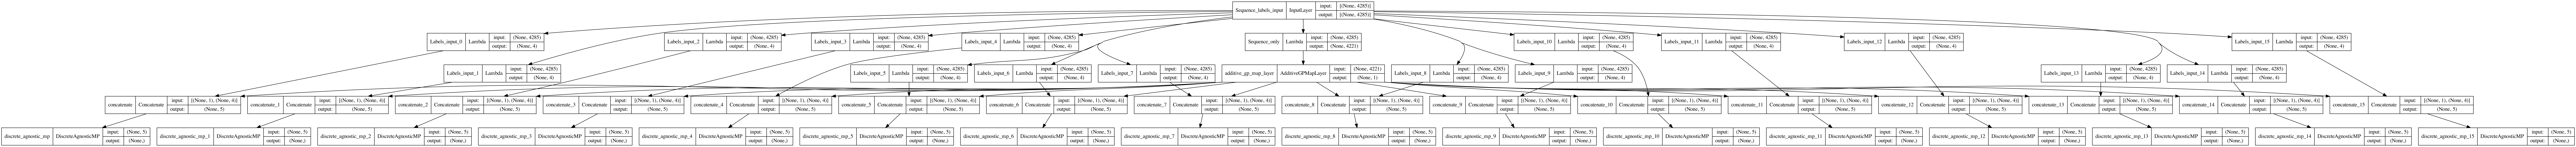

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=300,to_file='titeseq_dar.png')

In [17]:

# Fit model to data
model.fit(learning_rate=.0005,
          epochs=300,
          batch_size=250,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/300
239/239 [==============================] - 16s 31ms/step - loss: 578717.9375 - discrete_agnostic_mp_loss: 35585.3398 - discrete_agnostic_mp_1_loss: 37736.9531 - discrete_agnostic_mp_2_loss: 39348.0391 - discrete_agnostic_mp_3_loss: 43641.0898 - discrete_agnostic_mp_4_loss: 41284.6992 - discrete_agnostic_mp_5_loss: 45725.0781 - discrete_agnostic_mp_6_loss: 42818.3906 - discrete_agnostic_mp_7_loss: 43815.8906 - discrete_agnostic_mp_8_loss: 39836.6055 - discrete_agnostic_mp_9_loss: 35160.9414 - discrete_agnostic_mp_10_loss: 38617.9766 - discrete_agnostic_mp_11_loss: 43021.9492 - discrete_agnostic_mp_12_loss: 23561.7773 - discrete_agnostic_mp_13_loss: 22046.3633 - discrete_agnostic_mp_14_loss: 21779.6113 - discrete_agnostic_mp_15_loss: 24737.3516 - I_var: -0.1309 - val_loss: 583494.5625 - val_discrete_agnostic_mp_loss: 39222.6992 - val_discrete_agnostic_mp_1_loss: 41326.9180 - val_discrete_agnostic_mp_2_loss: 41678.0430 - val_discrete_agnostic_mp_3_loss: 47498.5000 - val_discre

239/239 [==============================] - 5s 19ms/step - loss: 518163.7188 - discrete_agnostic_mp_loss: 30745.7422 - discrete_agnostic_mp_1_loss: 32871.7695 - discrete_agnostic_mp_2_loss: 35035.8047 - discrete_agnostic_mp_3_loss: 38825.1133 - discrete_agnostic_mp_4_loss: 36637.8906 - discrete_agnostic_mp_5_loss: 41460.6328 - discrete_agnostic_mp_6_loss: 39353.7266 - discrete_agnostic_mp_7_loss: 40283.8320 - discrete_agnostic_mp_8_loss: 37815.0938 - discrete_agnostic_mp_9_loss: 31028.3809 - discrete_agnostic_mp_10_loss: 34649.6328 - discrete_agnostic_mp_11_loss: 39773.5586 - discrete_agnostic_mp_12_loss: 19931.8477 - discrete_agnostic_mp_13_loss: 18093.8438 - discrete_agnostic_mp_14_loss: 19650.2852 - discrete_agnostic_mp_15_loss: 22006.1797 - I_var: -0.0212 - val_loss: 560327.1250 - val_discrete_agnostic_mp_loss: 36616.8867 - val_discrete_agnostic_mp_1_loss: 38858.3516 - val_discrete_agnostic_mp_2_loss: 39045.3477 - val_discrete_agnostic_mp_3_loss: 44781.4492 - val_discrete_agnostic_m

239/239 [==============================] - 5s 20ms/step - loss: 428303.0938 - discrete_agnostic_mp_loss: 23403.3359 - discrete_agnostic_mp_1_loss: 25970.4297 - discrete_agnostic_mp_2_loss: 29310.6680 - discrete_agnostic_mp_3_loss: 28577.4180 - discrete_agnostic_mp_4_loss: 27671.2441 - discrete_agnostic_mp_5_loss: 31268.5039 - discrete_agnostic_mp_6_loss: 29282.8574 - discrete_agnostic_mp_7_loss: 31216.2520 - discrete_agnostic_mp_8_loss: 28968.5762 - discrete_agnostic_mp_9_loss: 26357.5996 - discrete_agnostic_mp_10_loss: 32263.5195 - discrete_agnostic_mp_11_loss: 36422.4961 - discrete_agnostic_mp_12_loss: 19085.7148 - discrete_agnostic_mp_13_loss: 17650.3496 - discrete_agnostic_mp_14_loss: 19100.9746 - discrete_agnostic_mp_15_loss: 21752.8711 - I_var: -0.0040 - val_loss: 449736.1562 - val_discrete_agnostic_mp_loss: 26938.8711 - val_discrete_agnostic_mp_1_loss: 29654.5332 - val_discrete_agnostic_mp_2_loss: 31505.6055 - val_discrete_agnostic_mp_3_loss: 32298.9668 - val_discrete_agnostic_m

239/239 [==============================] - 5s 22ms/step - loss: 411297.0625 - discrete_agnostic_mp_loss: 22241.9395 - discrete_agnostic_mp_1_loss: 24912.3730 - discrete_agnostic_mp_2_loss: 28442.7754 - discrete_agnostic_mp_3_loss: 26906.2871 - discrete_agnostic_mp_4_loss: 26131.2617 - discrete_agnostic_mp_5_loss: 29648.7910 - discrete_agnostic_mp_6_loss: 27555.2168 - discrete_agnostic_mp_7_loss: 29434.4629 - discrete_agnostic_mp_8_loss: 26965.4609 - discrete_agnostic_mp_9_loss: 24883.2754 - discrete_agnostic_mp_10_loss: 31574.9922 - discrete_agnostic_mp_11_loss: 35444.9258 - discrete_agnostic_mp_12_loss: 18924.5508 - discrete_agnostic_mp_13_loss: 17543.0938 - discrete_agnostic_mp_14_loss: 19003.1367 - discrete_agnostic_mp_15_loss: 21684.0703 - I_var: -0.0054 - val_loss: 428328.8438 - val_discrete_agnostic_mp_loss: 25184.8242 - val_discrete_agnostic_mp_1_loss: 27900.6699 - val_discrete_agnostic_mp_2_loss: 30160.1387 - val_discrete_agnostic_mp_3_loss: 29889.9180 - val_discrete_agnostic_m

239/239 [==============================] - 6s 26ms/step - loss: 400774.7812 - discrete_agnostic_mp_loss: 21631.4727 - discrete_agnostic_mp_1_loss: 24253.0898 - discrete_agnostic_mp_2_loss: 27899.7637 - discrete_agnostic_mp_3_loss: 25984.0898 - discrete_agnostic_mp_4_loss: 25153.1055 - discrete_agnostic_mp_5_loss: 28626.0215 - discrete_agnostic_mp_6_loss: 26499.0801 - discrete_agnostic_mp_7_loss: 28294.6934 - discrete_agnostic_mp_8_loss: 25573.3105 - discrete_agnostic_mp_9_loss: 24068.1660 - discrete_agnostic_mp_10_loss: 31109.1660 - discrete_agnostic_mp_11_loss: 34716.9883 - discrete_agnostic_mp_12_loss: 18822.8047 - discrete_agnostic_mp_13_loss: 17495.4551 - discrete_agnostic_mp_14_loss: 18968.6797 - discrete_agnostic_mp_15_loss: 21678.5215 - I_var: -0.0070 - val_loss: 417789.5000 - val_discrete_agnostic_mp_loss: 24425.6875 - val_discrete_agnostic_mp_1_loss: 27095.0918 - val_discrete_agnostic_mp_2_loss: 29552.0410 - val_discrete_agnostic_mp_3_loss: 28785.4023 - val_discrete_agnostic_m

239/239 [==============================] - 6s 25ms/step - loss: 395599.9688 - discrete_agnostic_mp_loss: 21335.3906 - discrete_agnostic_mp_1_loss: 23811.5234 - discrete_agnostic_mp_2_loss: 27504.6973 - discrete_agnostic_mp_3_loss: 25540.9863 - discrete_agnostic_mp_4_loss: 24515.2520 - discrete_agnostic_mp_5_loss: 28264.7676 - discrete_agnostic_mp_6_loss: 26084.3594 - discrete_agnostic_mp_7_loss: 27782.3242 - discrete_agnostic_mp_8_loss: 24898.1309 - discrete_agnostic_mp_9_loss: 23798.4473 - discrete_agnostic_mp_10_loss: 30895.8066 - discrete_agnostic_mp_11_loss: 34297.7344 - discrete_agnostic_mp_12_loss: 18759.8047 - discrete_agnostic_mp_13_loss: 17476.0762 - discrete_agnostic_mp_14_loss: 18955.6133 - discrete_agnostic_mp_15_loss: 21678.5723 - I_var: -0.0053 - val_loss: 411574.6250 - val_discrete_agnostic_mp_loss: 23934.2402 - val_discrete_agnostic_mp_1_loss: 26466.5039 - val_discrete_agnostic_mp_2_loss: 28999.4785 - val_discrete_agnostic_mp_3_loss: 28148.9922 - val_discrete_agnostic_m

239/239 [==============================] - 5s 20ms/step - loss: 391346.1875 - discrete_agnostic_mp_loss: 20981.1016 - discrete_agnostic_mp_1_loss: 23202.1543 - discrete_agnostic_mp_2_loss: 26968.7891 - discrete_agnostic_mp_3_loss: 25102.4238 - discrete_agnostic_mp_4_loss: 23993.2402 - discrete_agnostic_mp_5_loss: 27924.1133 - discrete_agnostic_mp_6_loss: 25716.3672 - discrete_agnostic_mp_7_loss: 27507.5840 - discrete_agnostic_mp_8_loss: 24523.8926 - discrete_agnostic_mp_9_loss: 23723.1699 - discrete_agnostic_mp_10_loss: 30813.2715 - discrete_agnostic_mp_11_loss: 34078.4922 - discrete_agnostic_mp_12_loss: 18721.6836 - discrete_agnostic_mp_13_loss: 17465.3281 - discrete_agnostic_mp_14_loss: 18947.2617 - discrete_agnostic_mp_15_loss: 21676.6582 - I_var: -0.0104 - val_loss: 409005.7500 - val_discrete_agnostic_mp_loss: 23544.3145 - val_discrete_agnostic_mp_1_loss: 25859.4277 - val_discrete_agnostic_mp_2_loss: 28411.8027 - val_discrete_agnostic_mp_3_loss: 27718.0098 - val_discrete_agnostic_m

239/239 [==============================] - 5s 20ms/step - loss: 387549.3750 - discrete_agnostic_mp_loss: 20673.2793 - discrete_agnostic_mp_1_loss: 22606.9297 - discrete_agnostic_mp_2_loss: 26587.8359 - discrete_agnostic_mp_3_loss: 24757.2148 - discrete_agnostic_mp_4_loss: 23655.5020 - discrete_agnostic_mp_5_loss: 27723.9590 - discrete_agnostic_mp_6_loss: 25528.9434 - discrete_agnostic_mp_7_loss: 27179.1074 - discrete_agnostic_mp_8_loss: 24225.1367 - discrete_agnostic_mp_9_loss: 23493.9355 - discrete_agnostic_mp_10_loss: 30581.9668 - discrete_agnostic_mp_11_loss: 33820.3633 - discrete_agnostic_mp_12_loss: 18664.2676 - discrete_agnostic_mp_13_loss: 17459.7637 - discrete_agnostic_mp_14_loss: 18935.1387 - discrete_agnostic_mp_15_loss: 21655.4883 - I_var: -0.0081 - val_loss: 403948.3125 - val_discrete_agnostic_mp_loss: 23152.9785 - val_discrete_agnostic_mp_1_loss: 25215.2539 - val_discrete_agnostic_mp_2_loss: 28032.0879 - val_discrete_agnostic_mp_3_loss: 27357.7188 - val_discrete_agnostic_m

239/239 [==============================] - 4s 19ms/step - loss: 382902.1562 - discrete_agnostic_mp_loss: 20180.7812 - discrete_agnostic_mp_1_loss: 21905.7402 - discrete_agnostic_mp_2_loss: 26084.9473 - discrete_agnostic_mp_3_loss: 24259.9238 - discrete_agnostic_mp_4_loss: 23293.3027 - discrete_agnostic_mp_5_loss: 27155.0430 - discrete_agnostic_mp_6_loss: 24988.0273 - discrete_agnostic_mp_7_loss: 26776.4160 - discrete_agnostic_mp_8_loss: 23759.2363 - discrete_agnostic_mp_9_loss: 23403.7480 - discrete_agnostic_mp_10_loss: 30611.8535 - discrete_agnostic_mp_11_loss: 33777.1719 - discrete_agnostic_mp_12_loss: 18660.2285 - discrete_agnostic_mp_13_loss: 17452.2383 - discrete_agnostic_mp_14_loss: 18923.4707 - discrete_agnostic_mp_15_loss: 21669.4434 - I_var: -0.0058 - val_loss: 402758.6562 - val_discrete_agnostic_mp_loss: 22570.5723 - val_discrete_agnostic_mp_1_loss: 24443.6484 - val_discrete_agnostic_mp_2_loss: 27431.2715 - val_discrete_agnostic_mp_3_loss: 26703.4883 - val_discrete_agnostic_m

239/239 [==============================] - 4s 17ms/step - loss: 377166.1250 - discrete_agnostic_mp_loss: 19514.2480 - discrete_agnostic_mp_1_loss: 21058.5859 - discrete_agnostic_mp_2_loss: 25473.1172 - discrete_agnostic_mp_3_loss: 23502.4727 - discrete_agnostic_mp_4_loss: 22611.3027 - discrete_agnostic_mp_5_loss: 26465.1348 - discrete_agnostic_mp_6_loss: 24581.7070 - discrete_agnostic_mp_7_loss: 26411.6504 - discrete_agnostic_mp_8_loss: 23349.8750 - discrete_agnostic_mp_9_loss: 23282.8691 - discrete_agnostic_mp_10_loss: 30587.6992 - discrete_agnostic_mp_11_loss: 33681.7539 - discrete_agnostic_mp_12_loss: 18637.7461 - discrete_agnostic_mp_13_loss: 17451.5566 - discrete_agnostic_mp_14_loss: 18905.6328 - discrete_agnostic_mp_15_loss: 21649.9668 - I_var: -0.0038 - val_loss: 394577.1562 - val_discrete_agnostic_mp_loss: 22086.0918 - val_discrete_agnostic_mp_1_loss: 23883.9688 - val_discrete_agnostic_mp_2_loss: 27086.7559 - val_discrete_agnostic_mp_3_loss: 26227.5684 - val_discrete_agnostic_m

239/239 [==============================] - 5s 21ms/step - loss: 374616.1875 - discrete_agnostic_mp_loss: 19154.9219 - discrete_agnostic_mp_1_loss: 20675.6035 - discrete_agnostic_mp_2_loss: 25224.4062 - discrete_agnostic_mp_3_loss: 23263.2930 - discrete_agnostic_mp_4_loss: 22344.1543 - discrete_agnostic_mp_5_loss: 25931.4023 - discrete_agnostic_mp_6_loss: 24463.7715 - discrete_agnostic_mp_7_loss: 26264.4180 - discrete_agnostic_mp_8_loss: 23323.3301 - discrete_agnostic_mp_9_loss: 23227.4766 - discrete_agnostic_mp_10_loss: 30499.3047 - discrete_agnostic_mp_11_loss: 33630.1992 - discrete_agnostic_mp_12_loss: 18614.5117 - discrete_agnostic_mp_13_loss: 17445.4453 - discrete_agnostic_mp_14_loss: 18901.3398 - discrete_agnostic_mp_15_loss: 21651.4277 - I_var: -0.0075 - val_loss: 388924.0625 - val_discrete_agnostic_mp_loss: 21360.9316 - val_discrete_agnostic_mp_1_loss: 23141.5098 - val_discrete_agnostic_mp_2_loss: 26529.5195 - val_discrete_agnostic_mp_3_loss: 25501.2246 - val_discrete_agnostic_m

239/239 [==============================] - 5s 19ms/step - loss: 369401.8125 - discrete_agnostic_mp_loss: 18624.2676 - discrete_agnostic_mp_1_loss: 20161.1055 - discrete_agnostic_mp_2_loss: 24805.0586 - discrete_agnostic_mp_3_loss: 22635.2598 - discrete_agnostic_mp_4_loss: 21697.8887 - discrete_agnostic_mp_5_loss: 25016.3301 - discrete_agnostic_mp_6_loss: 23889.1758 - discrete_agnostic_mp_7_loss: 25933.6641 - discrete_agnostic_mp_8_loss: 22908.9707 - discrete_agnostic_mp_9_loss: 23090.3906 - discrete_agnostic_mp_10_loss: 30508.9238 - discrete_agnostic_mp_11_loss: 33535.3008 - discrete_agnostic_mp_12_loss: 18601.0566 - discrete_agnostic_mp_13_loss: 17443.6113 - discrete_agnostic_mp_14_loss: 18897.3555 - discrete_agnostic_mp_15_loss: 21652.2305 - I_var: -0.0058 - val_loss: 385534.7812 - val_discrete_agnostic_mp_loss: 21058.8750 - val_discrete_agnostic_mp_1_loss: 22936.6426 - val_discrete_agnostic_mp_2_loss: 26372.9082 - val_discrete_agnostic_mp_3_loss: 25113.0762 - val_discrete_agnostic_m

239/239 [==============================] - 4s 18ms/step - loss: 366976.0312 - discrete_agnostic_mp_loss: 18364.9062 - discrete_agnostic_mp_1_loss: 19934.4512 - discrete_agnostic_mp_2_loss: 24605.2910 - discrete_agnostic_mp_3_loss: 22232.2598 - discrete_agnostic_mp_4_loss: 21277.9316 - discrete_agnostic_mp_5_loss: 24538.6367 - discrete_agnostic_mp_6_loss: 23642.0449 - discrete_agnostic_mp_7_loss: 25856.0684 - discrete_agnostic_mp_8_loss: 22879.3789 - discrete_agnostic_mp_9_loss: 23057.5898 - discrete_agnostic_mp_10_loss: 30476.9766 - discrete_agnostic_mp_11_loss: 33527.7930 - discrete_agnostic_mp_12_loss: 18597.1133 - discrete_agnostic_mp_13_loss: 17442.8086 - discrete_agnostic_mp_14_loss: 18887.6250 - discrete_agnostic_mp_15_loss: 21653.8008 - I_var: -0.0053 - val_loss: 383935.1562 - val_discrete_agnostic_mp_loss: 20907.8398 - val_discrete_agnostic_mp_1_loss: 22768.5781 - val_discrete_agnostic_mp_2_loss: 26284.4277 - val_discrete_agnostic_mp_3_loss: 24802.4512 - val_discrete_agnostic_m

239/239 [==============================] - 4s 17ms/step - loss: 365010.1562 - discrete_agnostic_mp_loss: 18256.8359 - discrete_agnostic_mp_1_loss: 19810.5977 - discrete_agnostic_mp_2_loss: 24495.2031 - discrete_agnostic_mp_3_loss: 22038.1504 - discrete_agnostic_mp_4_loss: 21047.1387 - discrete_agnostic_mp_5_loss: 24122.1250 - discrete_agnostic_mp_6_loss: 23321.8926 - discrete_agnostic_mp_7_loss: 25746.5117 - discrete_agnostic_mp_8_loss: 22820.2559 - discrete_agnostic_mp_9_loss: 22951.7070 - discrete_agnostic_mp_10_loss: 30380.7422 - discrete_agnostic_mp_11_loss: 33457.3477 - discrete_agnostic_mp_12_loss: 18582.6914 - discrete_agnostic_mp_13_loss: 17440.3203 - discrete_agnostic_mp_14_loss: 18890.4805 - discrete_agnostic_mp_15_loss: 21646.6641 - I_var: -0.0077 - val_loss: 386284.9062 - val_discrete_agnostic_mp_loss: 21159.2910 - val_discrete_agnostic_mp_1_loss: 23081.1992 - val_discrete_agnostic_mp_2_loss: 26497.8223 - val_discrete_agnostic_mp_3_loss: 25252.6562 - val_discrete_agnostic_m

239/239 [==============================] - 4s 17ms/step - loss: 363962.6875 - discrete_agnostic_mp_loss: 18189.9277 - discrete_agnostic_mp_1_loss: 19741.1348 - discrete_agnostic_mp_2_loss: 24427.1602 - discrete_agnostic_mp_3_loss: 21895.0469 - discrete_agnostic_mp_4_loss: 20888.8398 - discrete_agnostic_mp_5_loss: 23909.8613 - discrete_agnostic_mp_6_loss: 23100.1680 - discrete_agnostic_mp_7_loss: 25701.7344 - discrete_agnostic_mp_8_loss: 22793.5820 - discrete_agnostic_mp_9_loss: 22919.3848 - discrete_agnostic_mp_10_loss: 30390.2676 - discrete_agnostic_mp_11_loss: 33448.6172 - discrete_agnostic_mp_12_loss: 18581.8184 - discrete_agnostic_mp_13_loss: 17443.8340 - discrete_agnostic_mp_14_loss: 18886.8652 - discrete_agnostic_mp_15_loss: 21642.9922 - I_var: -0.0070 - val_loss: 381078.5938 - val_discrete_agnostic_mp_loss: 20823.2559 - val_discrete_agnostic_mp_1_loss: 22704.2832 - val_discrete_agnostic_mp_2_loss: 26202.3301 - val_discrete_agnostic_mp_3_loss: 24637.8848 - val_discrete_agnostic_m

239/239 [==============================] - 4s 16ms/step - loss: 363979.3438 - discrete_agnostic_mp_loss: 18166.3516 - discrete_agnostic_mp_1_loss: 19714.5332 - discrete_agnostic_mp_2_loss: 24399.3262 - discrete_agnostic_mp_3_loss: 21852.5117 - discrete_agnostic_mp_4_loss: 20824.3496 - discrete_agnostic_mp_5_loss: 23872.9688 - discrete_agnostic_mp_6_loss: 23013.2344 - discrete_agnostic_mp_7_loss: 25804.8496 - discrete_agnostic_mp_8_loss: 22876.6562 - discrete_agnostic_mp_9_loss: 22984.8066 - discrete_agnostic_mp_10_loss: 30392.6230 - discrete_agnostic_mp_11_loss: 33517.2266 - discrete_agnostic_mp_12_loss: 18584.0723 - discrete_agnostic_mp_13_loss: 17440.2227 - discrete_agnostic_mp_14_loss: 18889.1387 - discrete_agnostic_mp_15_loss: 21644.7324 - I_var: -0.0048 - val_loss: 383689.8750 - val_discrete_agnostic_mp_loss: 21116.6895 - val_discrete_agnostic_mp_1_loss: 23010.1621 - val_discrete_agnostic_mp_2_loss: 26437.5996 - val_discrete_agnostic_mp_3_loss: 25134.3359 - val_discrete_agnostic_m

On test data:


Text(0.5, 1.0, 'training hisotry')

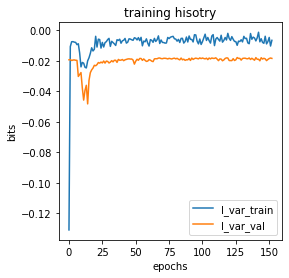

In [18]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

In [19]:
phi = gpmap.x_to_phi(x_test)

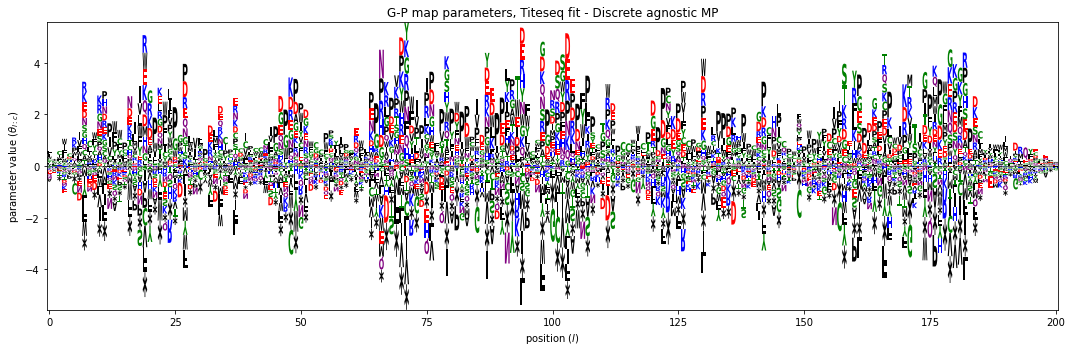

In [20]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
# Y = mp_mpa.Y    # Y = number of bins
# y_lim = [-.5, Y-.5]
# y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,1,figsize=[15,5])

# Left panel: draw logo using logomaker
ax = axs
logo = logomaker.Logo(-pd.DataFrame(theta,columns=model.alphabet), ax=ax,center_values=True,color_scheme='chemistry')
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters, Titeseq fit - Discrete agnostic MP')

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout()
fig.savefig('ace2rbd_g-p_map_mpa_titeseq_only_DA-MP.png',dpi=300,bbox_inches='tight')
plt.show()

In [21]:
np.save('titeseq_gpmap_discrete_agnostic',logo.df.values.ravel())

In [25]:
sortseq_gpmap = np.load('sortseq_gpmap_discrete_agnostic.npy')
titeseq_gpmap = -np.load('titeseq_gpmap_discrete_agnostic.npy')

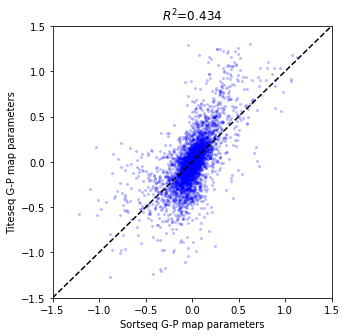

In [28]:
plt.figure(figsize=(5,5))
# Compute R^2 between yhat_test and y_test
Rsq = np.corrcoef(sortseq_gpmap,titeseq_gpmap)[0, 1]**2

# Style plot
xlim = [-1.5, 1.5]

plt.scatter(sortseq_gpmap,titeseq_gpmap,s=4,color='blue',alpha=0.2)
plt.xlabel('Sortseq G-P map parameters')
plt.ylabel('Titeseq G-P map parameters')
plt.title(f'$R^2$={Rsq:.3}');
plt.plot(xlim, xlim, '--', color='k', label='diagonal')
plt.xlim(xlim)
plt.ylim(xlim)
plt.show()

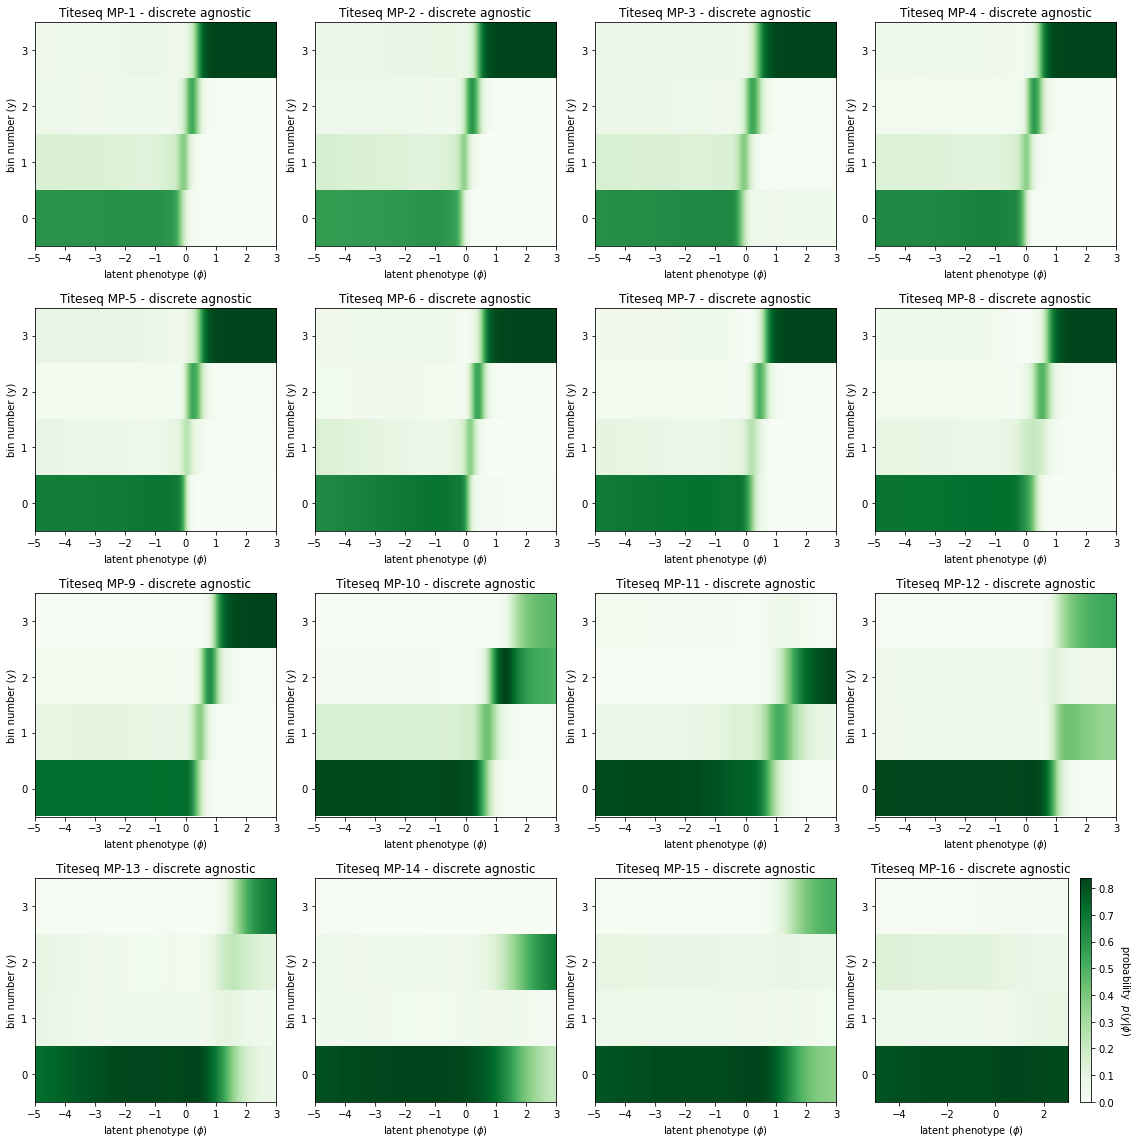

In [24]:
# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_list[0].Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(4,4,figsize=[16,16])

mp_counter = 0
for i in range(4):
    for j in range(4):
        
        measurement_process = mp_list[mp_counter].p_of_y_given_phi(y_all, phi_grid)
        # Right panel: draw measurement process as heatmap
        ax = axs[i,j]

        im = ax.imshow(measurement_process,
                       cmap='Greens',
                       extent=phi_lim+y_lim,
                       vmin=0,
                       origin='lower',
                       interpolation='nearest',
                       aspect="auto")
        ax.set_yticks(y_all)
        ax.set_ylabel('bin number (y)')
        ax.set_xlabel('latent phenotype ($\phi$)')
        ax.set_title(f'Titeseq MP-{mp_counter+1} - discrete agnostic')
        mp_counter+=1
        
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()

fig.savefig('ace2rbd_mpa_measurment_prcoess_expression.png',dpi=300,bbox_inches='tight')
